# A simple example of classifier

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms

## Steps:

1. Load traning and test datasets using `torchvision`
2. Define a simple convolutional neural network
3. Define a loss function
4. Train the network on the training dataset
5. Test the network on the test dataset

## 1 Loading

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

100%|█████████▉| 170385408/170498071 [00:41<00:00, 2331879.61it/s]

Files already downloaded and verified


170500096it [01:00, 2331879.61it/s]                               

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

horse    deer     dog      horse   


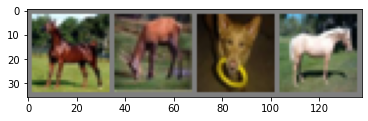

In [18]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[i]]:8s}' for i in range(batch_size)))

## 2 Define Convolutional neural networks

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
## Note: customize your model using `nn.Module`
class Mynet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [31]:
net = Mynet()

## 3 Define Loss

In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

## 4 Train the network

In [34]:
for epoch in range(2):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + opimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')



[1,  2000] loss: 2.192
[1,  4000] loss: 1.825
[1,  6000] loss: 1.648
[1,  8000] loss: 1.551
[1, 10000] loss: 1.485
[1, 12000] loss: 1.433
[2,  2000] loss: 1.362
[2,  4000] loss: 1.371
[2,  6000] loss: 1.319
[2,  8000] loss: 1.320
[2, 10000] loss: 1.295
[2, 12000] loss: 1.261
Finished Training


In [35]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5 Test the network on the test data

GroundTruth:  truck cat   plane truck


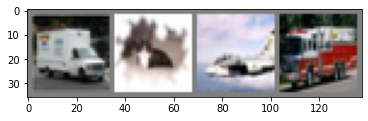

In [37]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[i]] :5s}' for i in range(batch_size)))

In [38]:
net = Mynet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [49]:
outputs = net(images)
a, predicted = torch.max(outputs, 1)
print(a, predicted)

print('Predicted', '  '.join(classes[predicted[i]] for i in range(batch_size)))

tensor([3.4122, 3.9144, 4.9365, 5.0068], grad_fn=<MaxBackward0>) tensor([9, 7, 0, 9])
Predicted truck  horse  plane  truck


## 6 Evaluate on whold test set

In [50]:
correct = 0
total = 0

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
print(f'Accuracy of the network on the 10000 test images: {100 * correct//total} %')


Accuracy of the network on the 10000 test images: 54 %


In [51]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 50.2 %
Accuracy for class: car   is 50.3 %
Accuracy for class: bird  is 30.6 %
Accuracy for class: cat   is 36.6 %
Accuracy for class: deer  is 53.2 %
Accuracy for class: dog   is 41.9 %
Accuracy for class: frog  is 60.0 %
Accuracy for class: horse is 77.9 %
Accuracy for class: ship  is 75.0 %
Accuracy for class: truck is 70.7 %
